In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [3]:
import cv2
import numpy as np
import h5py
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from google.colab.patches import cv2_imshow
from scipy.signal import find_peaks, butter, filtfilt
import math
import scipy
from scipy import signal
import sys

## HDF5 저장된 신호로 HR측정

52


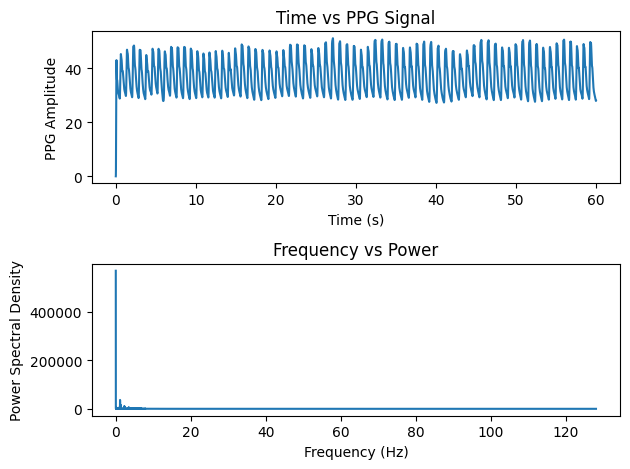

In [4]:
success = 0
bpm = 0.0
bpm_avg = 0.0
rmse = 0.0
error = []
sampling_rate_hdf = 256  # samplingrate of COHFACE
count = 0  # Reading at 60Hz
i = 0
test_length = 60
test = [50, 50, 50]

file = "/content/drive/MyDrive/everglow/cohface/2/1/data.hdf5"
with h5py.File(file, "r") as f:
    # print("Key: %s" % f.keys())
    PPG_Signal = np.asarray(f['pulse'])

    time = np.asarray(f['time'])
    idx = np.where(time == 60)[0]
    idx = int(idx[0])
    PPG_Signal = PPG_Signal[:idx]
    time = time[:idx]

    # FFT를 사용해 신호의 주파수 도메인 변환
    # FFT를 적용하는 이유: 노이즈 제거, 신호분석, 생리적 정보 추출
    psd = np.abs(scipy.fft.rfft(PPG_Signal, PPG_Signal.size))
    freqs = scipy.fft.rfftfreq(PPG_Signal.size, 1 / sampling_rate_hdf)

    # 신호에서 피크 찾기
    mean = np.mean(PPG_Signal)
    peak_indices, _ = signal.find_peaks(PPG_Signal, distance=220)
    print(len(peak_indices))
    IBI = []
    # IBI 계산
    # IBI(Inter-Beat Interval): 연속적인 심작 박동 사이의 시간간격
    for i in np.arange(len(peak_indices) - 1):
        tmp = peak_indices[i + 1] - peak_indices[i]
        IBI.append(tmp)
    # 샘플링 레이트로 나누어 각 IBI의 시간(초 단위)을 계산. 샘플링 레이트는 초당 샘플 수를 의미, 이를 나누면 실제 시간(초)을 얻을 수 있음
    IBI = np.asarray(IBI) / sampling_rate_hdf
    # 모든 IBI 값의 평균을 계산. 이 평균 IBI 값은 연속적인 심장 박동 사이의 평균 시간 간격
    IBI = np.mean(IBI)

    # IBI기반 평균 HR 계산 (IBI의 역수를 취하고 60을 곱해서 BPM을 얻을 수 있음)
    bpm_avg = (60/IBI)

    plt.subplot(2,1,1)
    plt.plot(time, PPG_Signal)
    plt.title('Time vs PPG Signal')  # 첫 번째 서브플롯의 제목
    plt.xlabel('Time (s)')  # x축 레이블
    plt.ylabel('PPG Amplitude')  # y축 레이블

    plt.subplot(2,1,2)
    plt.plot(freqs[:], psd[:])
    plt.title('Frequency vs Power')  # 두 번째 서브플롯의 제목
    plt.xlabel('Frequency (Hz)')  # x축 레이블
    plt.ylabel('Power Spectral Density')  # y축 레이블

    plt.tight_layout()  # 서브플롯 간 겹침 방지
    plt.show()

# Print average HR based on IBI (Ground truth)
print("GT BPM is: " + str(bpm_avg))
for i in range(len(test)):
    error.append(test[i] - bpm_avg)

# RMSE: 실제 값과 예측 값 사이의 오차 제곱에 대한 평균값의 제곱근 위 test 데이터[50, 50, 50]
rmse = np.sum(np.square(error))
rmse = np.sqrt(rmse/len(test))
print('RMSE is: ' + str(np.round(rmse, 2)))

# Success Rate: 성공률은 계산된 심박수가 실제 심박수(테스트 데이터)와 ±5 BPM 이내일 때를 성공으로 간주할 때의 비율
error = np.asarray(error)
success = np.where(np.abs(error) <= 5.)[0]
print('Success Rate is: ' + str(len(success)/len(test)))
# print('Success Rate is ', 1 - fail/count)

# Mean Error: 평균 오류는 실제 값과 예측 값 사이의 차이의 평균값
print('Mean Error is: ' + str(np.round(np.mean(np.abs(error)), 2)))

# Standard Deviation: 오차의 표준 편차
print('Standard Deviation is: ' + str(np.round(np.std(error), 2)))

## 영상기반 HR 측정

In [5]:
# PPG peak detection 함수 정의
def detect_peaks(data, threshold=0.5):
    peaks = np.where(data > threshold)[0]
    return peaks

GT BPM is: 51.69669372401505
RMSE is: 1.7
Success Rate is: 1.0
Mean Error is: 1.7
Standard Deviation is: 0.0


In [6]:
# Mediapipe Face 모듈을 로드합니다.
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

In [7]:
# 비디오 파일 로드 및 전처리
video_path = f"/content/drive/MyDrive/everglow/cohface/2/1/data.avi"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

# 비디오 프레임을 읽어와서 Green 채널의 평균 강도 추출
green_channel_intensities = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # BGR 이미지를 RGB 이미지로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 얼굴 감지
    results = face_detection.process(frame_rgb)
    if results.detections:
        # 여러 얼굴이 감지되더라도 첫 번째 얼굴만 사용합니다.
        detection = results.detections[0]
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = frame.shape
        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
        face_roi = frame[y:y+h, x:x+w]

        # Green 채널 추출 및 평균 강도 계산
        green_channel = face_roi[:, :, 1]  # Green 채널은 [G, B, R]에서 인덱스 1에 해당합니다.
        green_channel_mean = np.mean(green_channel)
        green_channel_intensities.append(green_channel_mean)

# 심박수 계산 코드 적용
sampling_rate_video = fps  # 비디오의 FPS를 샘플링 레이트로 사용
time = np.arange(len(green_channel_intensities)) / sampling_rate_video
print('Time: ',len(time)/fps)
# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(scipy.fft.rfft(green_channel_intensities))
freqs = scipy.fft.rfftfreq(len(green_channel_intensities), 1 / sampling_rate_video)

# 신호에서 피크 찾기 (distance를 크게하면 BPM 값이 작아짐)
# distance 매개변수는 피크 간의 최소 거리를 지정
peak_indices, _ = find_peaks(green_channel_intensities, distance=19)
IBI = np.diff(peak_indices) / sampling_rate_video
bpm_avg = (60 / np.mean(IBI))

# 결과 출력
print("Video based BPM is:", bpm_avg)

Time:  60.4
Video based BPM is: 47.67540152155537


## HDF5파일과 영상기반 BPM 오차 계산

In [8]:
file = "/content/drive/MyDrive/everglow/cohface/2/1/data.hdf5"
with h5py.File(file, "r") as f:
    # print("Key: %s" % f.keys())
    PPG_Signal = np.asarray(f['pulse'])

    time = np.asarray(f['time'])
    idx = np.where(time == 60)[0]
    idx = int(idx[0])
    PPG_Signal = PPG_Signal[:idx]
    time = time[:idx]

    # FFT를 사용해 신호의 주파수 도메인 변환
    # FFT를 적용하는 이유: 노이즈 제거, 신호분석, 생리적 정보 추출
    psd = np.abs(scipy.fft.rfft(PPG_Signal, PPG_Signal.size))
    freqs = scipy.fft.rfftfreq(PPG_Signal.size, 1 / sampling_rate_hdf)

    # 신호에서 피크 찾기
    mean = np.mean(PPG_Signal)
    peak_indices, _ = signal.find_peaks(PPG_Signal, distance=220)
    IBI = []
    # IBI 계산
    # IBI(Inter-Beat Interval): 연속적인 심작 박동 사이의 시간간격
    for i in np.arange(len(peak_indices) - 1):
        tmp = peak_indices[i + 1] - peak_indices[i]
        IBI.append(tmp)
    # 샘플링 레이트로 나누어 각 IBI의 시간(초 단위)을 계산. 샘플링 레이트는 초당 샘플 수를 의미, 이를 나누면 실제 시간(초)을 얻을 수 있음
    IBI = np.asarray(IBI) / sampling_rate_hdf
    # 모든 IBI 값의 평균을 계산. 이 평균 IBI 값은 연속적인 심장 박동 사이의 평균 시간 간격
    IBI = np.mean(IBI)

    # IBI기반 평균 HR 계산 (IBI의 역수를 취하고 60을 곱해서 BPM을 얻을 수 있음)
    bpm_actual = (60/IBI)

print("GT BPM is: " + str(bpm_actual))

# 비디오 파일 로드 및 전처리
video_path = f"/content/drive/MyDrive/everglow/cohface/2/1/data.avi"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

# 비디오 프레임을 읽어와서 Green 채널의 평균 강도 추출
green_channel_intensities = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # BGR 이미지를 RGB 이미지로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 얼굴 감지
    results = face_detection.process(frame_rgb)
    if results.detections:
        # 여러 얼굴이 감지되더라도 첫 번째 얼굴만 사용합니다.
        detection = results.detections[0]
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = frame.shape
        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
        face_roi = frame[y:y+h, x:x+w]

        # Green 채널 추출 및 평균 강도 계산
        green_channel = face_roi[:, :, 1]  # Green 채널은 [G, B, R]에서 인덱스 1에 해당합니다.
        green_channel_mean = np.mean(green_channel)
        green_channel_intensities.append(green_channel_mean)

# 심박수 계산 코드 적용
sampling_rate_video = fps  # 비디오의 FPS를 샘플링 레이트로 사용
time = np.arange(len(green_channel_intensities)) / sampling_rate_video

# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(scipy.fft.rfft(green_channel_intensities))
freqs = scipy.fft.rfftfreq(len(green_channel_intensities), 1 / sampling_rate_video)

# 신호에서 피크 찾기 (distance를 크게하면 BPM 값이 작아짐)
# distance 매개변수는 피크 간의 최소 거리를 지정
peak_indices, _ = find_peaks(green_channel_intensities, distance=19)
IBI = np.diff(peak_indices) / sampling_rate_video
bpm_predicted = (60 / np.mean(IBI))

# 오차 계산
errors = np.array(bpm_actual) - np.array(bpm_predicted)

# RMSE 계산
rmse = np.sqrt(np.mean(errors**2))

# Mean Error 계산
mean_error = np.mean(np.abs(errors))

# Standard Deviation 계산
std_dev = np.std(errors)
print("Video based BPM is:", bpm_predicted)
print(f'RMSE: {rmse}')
print(f'Mean Error: {mean_error}')
print(f'Standard Deviation: {std_dev}')

GT BPM is: 51.69669372401505
Video based BPM is: 47.67540152155537
RMSE: 4.0212922024596764
Mean Error: 4.0212922024596764
Standard Deviation: 0.0


## 모든 data의 HDF5 BPM과 영상기반 BPM

In [9]:
# 전체 참가자 수와 각 참가자별 영상 개수
subjects = range(1, 41)
numbers = range(0, 4)

# 결과를 저장할 리스트
gt_bpm_results = []
video_bpm_results = []

for subject in subjects:
    for number in numbers:
        hdf5_path = f"/content/drive/MyDrive/everglow/cohface/{subject}/{number}/data.hdf5"
        video_path = f"/content/drive/MyDrive/everglow/cohface/{subject}/{number}/data.avi"

        sampling_rate_hdf = 256
        with h5py.File(hdf5_path, "r") as f:
            # print("Key: %s" % f.keys())
            PPG_Signal = np.asarray(f['pulse'])

            time = np.asarray(f['time'])
            idx = np.where(time == 60)[0]
            # idx = int(idx[0])
            PPG_Signal = PPG_Signal[:]
            time = time[:]

            # FFT를 사용해 신호의 주파수 도메인 변환
            # FFT를 적용하는 이유: 노이즈 제거, 신호분석, 생리적 정보 추출
            psd = np.abs(scipy.fft.rfft(PPG_Signal, PPG_Signal.size))
            freqs = scipy.fft.rfftfreq(PPG_Signal.size, 1 / sampling_rate_hdf)

            # 신호에서 피크 찾기
            mean = np.mean(PPG_Signal)
            peak_indices, _ = signal.find_peaks(PPG_Signal, distance=220)
            IBI = []
            # IBI 계산
            # IBI(Inter-Beat Interval): 연속적인 심작 박동 사이의 시간간격
            for i in np.arange(len(peak_indices) - 1):
                tmp = peak_indices[i + 1] - peak_indices[i]
                IBI.append(tmp)
            # 샘플링 레이트로 나누어 각 IBI의 시간(초 단위)을 계산. 샘플링 레이트는 초당 샘플 수를 의미, 이를 나누면 실제 시간(초)을 얻을 수 있음
            IBI = np.asarray(IBI) / sampling_rate_hdf
            # 모든 IBI 값의 평균을 계산. 이 평균 IBI 값은 연속적인 심장 박동 사이의 평균 시간 간격
            IBI = np.mean(IBI)

            # IBI기반 평균 HR 계산 (IBI의 역수를 취하고 60을 곱해서 BPM을 얻을 수 있음)
            gt_bpm  = (60/IBI)

        # 비디오 처리 코드 여기에 삽입...
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)

        # 비디오 프레임을 읽어와서 Green 채널의 평균 강도 추출
        green_channel_intensities = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # BGR 이미지를 RGB 이미지로 변환
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # 얼굴 감지
            results = face_detection.process(frame_rgb)
            if results.detections:
                # 여러 얼굴이 감지되더라도 첫 번째 얼굴만 사용합니다.
                detection = results.detections[0]
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = frame.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                face_roi = frame[y:y+h, x:x+w]

                # Green 채널 추출 및 평균 강도 계산
                green_channel = face_roi[:, :, 1]  # Green 채널은 [G, B, R]에서 인덱스 1에 해당합니다.
                green_channel_mean = np.mean(green_channel)
                green_channel_intensities.append(green_channel_mean)
        # 심박수 계산 코드 적용
        sampling_rate_video = fps  # 비디오의 FPS를 샘플링 레이트로 사용
        time = np.arange(len(green_channel_intensities)) / sampling_rate_video

        # FFT를 사용해 신호의 주파수 도메인 변환
        psd = np.abs(scipy.fft.rfft(green_channel_intensities))
        freqs = scipy.fft.rfftfreq(len(green_channel_intensities), 1 / sampling_rate_video)

        # 신호에서 피크 찾기 (distance를 크게하면 BPM 값이 작아짐)
        # distance 매개변수는 피크 간의 최소 거리를 지정
        peak_indices, _ = find_peaks(green_channel_intensities, distance=19)
        IBI = np.diff(peak_indices) / sampling_rate_video
        video_bpm = (60 / np.mean(IBI))

        # 결과 저장
        gt_bpm_results.append(gt_bpm)
        video_bpm_results.append(video_bpm)

for subject in subjects:
    for i, number in enumerate(numbers):
        idx = (subject - 1) * len(numbers) + i
        print(f"Subject {subject}, Video {number} - GT BPM: {gt_bpm_results[idx]}, Video BPM: {video_bpm_results[idx]}")

Subject 1, Video 0 - GT BPM: 46.96025499251935, Video BPM: 48.081841432225076
Subject 1, Video 1 - GT BPM: 47.003060095058274, Video BPM: 46.779661016949156
Subject 1, Video 2 - GT BPM: 46.91945016269341, Video BPM: 47.39495798319327
Subject 1, Video 3 - GT BPM: 44.86563676489679, Video BPM: 45.64666103127642
Subject 2, Video 0 - GT BPM: 50.98340383989587, Video BPM: 41.730279898218825
Subject 2, Video 1 - GT BPM: 51.88515005846433, Video BPM: 47.67540152155537
Subject 2, Video 2 - GT BPM: 49.21467337997777, Video BPM: 48.040033361134284
Subject 2, Video 3 - GT BPM: 53.270514330585, Video BPM: 47.1571906354515
Subject 3, Video 0 - GT BPM: 56.60064486411792, Video BPM: 46.30872483221478
Subject 3, Video 1 - GT BPM: 46.71714230246555, Video BPM: 46.80497925311203
Subject 3, Video 2 - GT BPM: 45.20601700457816, Video BPM: 46.03580562659847
Subject 3, Video 3 - GT BPM: 45.51260946862448, Video BPM: 46.0
Subject 4, Video 0 - GT BPM: 54.01758384890915, Video BPM: 46.921797004991674
Subject 4

## 아래 코드는 영상에서 Green channel에 가우시안 스무딩과 미분하는 코드

In [10]:
# HDF5 파일 경로
hdf5_file_path = "/content/drive/MyDrive/everglow/cohface/2/1/data.hdf5"

# HDF5 파일 열기 (읽기 모드)
with h5py.File(hdf5_file_path, 'r') as file:
    # 각 데이터셋 읽기
    pulse_dataset = file['pulse'][:]
    respiration_dataset = file['respiration'][:]
    time_dataset = file['time'][:]

    # 데이터셋 확인
    print("Pulse dataset shape:", pulse_dataset.shape)
    print("Respiration dataset shape:", respiration_dataset.shape)
    print("Time dataset shape:", time_dataset.shape)

Pulse dataset shape: (15488,)
Respiration dataset shape: (15488,)
Time dataset shape: (15488,)


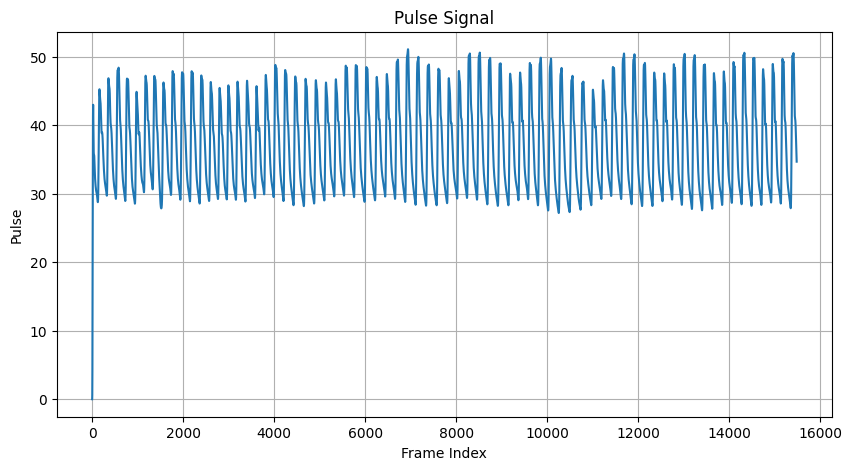

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(pulse_dataset)
plt.title('Pulse Signal')
plt.xlabel('Frame Index')
plt.ylabel('Pulse')
plt.grid(True)
plt.show()

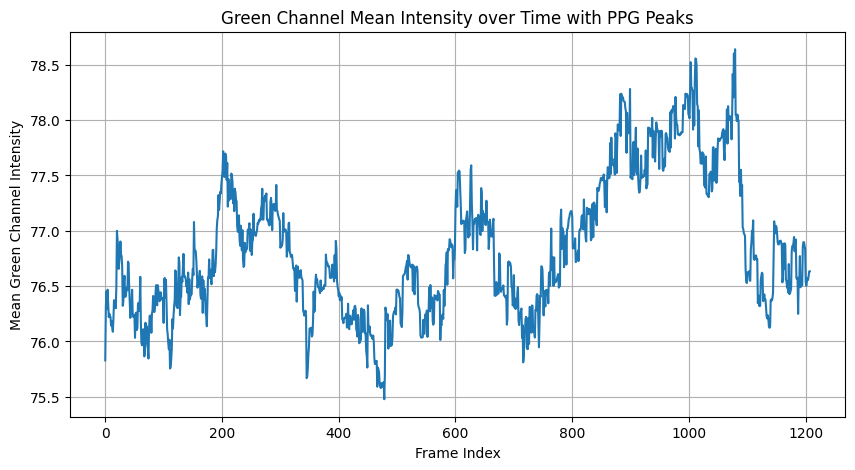

In [12]:
# Cohface 데이터셋 경로 설정
dataset_folder = "/content/drive/MyDrive/everglow/cohface/2/1/"

# 비디오 파일 로드 및 전처리
video_path = f"{dataset_folder}/data.avi"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

# PPG 데이터 로드
hdf5_path = f"{dataset_folder}/data.hdf5"
with h5py.File(hdf5_path, "r") as hf:
    pulse_data = np.array(hf['pulse'])
    respiration_data = np.array(hf['respiration'])
    time_data = np.array(hf['time'])

# Mediapipe Face 모듈을 로드합니다.
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

# PPG peak detection 함수 정의
def detect_peaks(data, threshold=0.5):
    peaks = np.where(data > threshold)[0]
    return peaks

# 비디오 프레임을 읽어와서 Green 채널의 평균 강도 추출
green_channel_intensities = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # BGR 이미지를 RGB 이미지로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 얼굴 감지
    results = face_detection.process(frame_rgb)
    if results.detections:
        # 여러 얼굴이 감지되더라도 첫 번째 얼굴만 사용합니다.
        detection = results.detections[0]
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = frame.shape
        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
        face_roi = frame[y:y+h, x:x+w]

        # Green 채널 추출 및 평균 강도 계산
        green_channel = face_roi[:, :, 1]  # Green 채널은 [G, B, R]에서 인덱스 1에 해당합니다.
        green_channel_mean = np.mean(green_channel)
        green_channel_intensities.append(green_channel_mean)

# Green 채널의 평균 강도에서의 PPG peak 탐지
green_peaks_list = detect_peaks(np.array(green_channel_intensities), threshold=0.5)

# Green 채널의 평균 강도 시각화
plt.figure(figsize=(10, 5))
plt.plot(green_channel_intensities)
# plt.scatter(green_peaks_list, np.array(green_channel_intensities)[green_peaks_list], c='r', marker='o')
plt.title('Green Channel Mean Intensity over Time with PPG Peaks')
plt.xlabel('Frame Index')
plt.ylabel('Mean Green Channel Intensity')
plt.grid(True)
plt.show()

# 비디오 처리 완료 후 해제
cap.release()

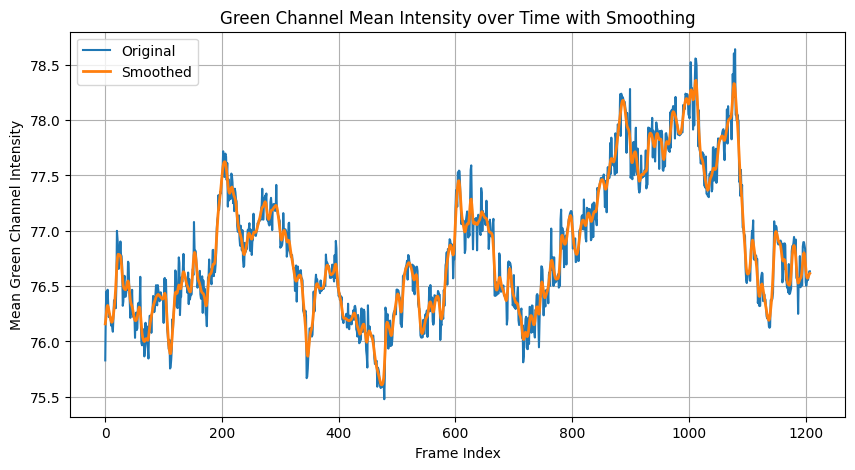

In [13]:
# Green 채널의 평균 강도에 Gaussian smoothing 적용
smoothed_green_channel = gaussian_filter(green_channel_intensities, sigma=2)

# Green 채널의 평균 강도와 스무딩된 신호 시각화
plt.figure(figsize=(10, 5))
plt.plot(green_channel_intensities, label='Original')
plt.plot(smoothed_green_channel, label='Smoothed', linewidth=2)
plt.title('Green Channel Mean Intensity over Time with Smoothing')
plt.xlabel('Frame Index')
plt.ylabel('Mean Green Channel Intensity')
plt.legend()
plt.grid(True)
plt.show()

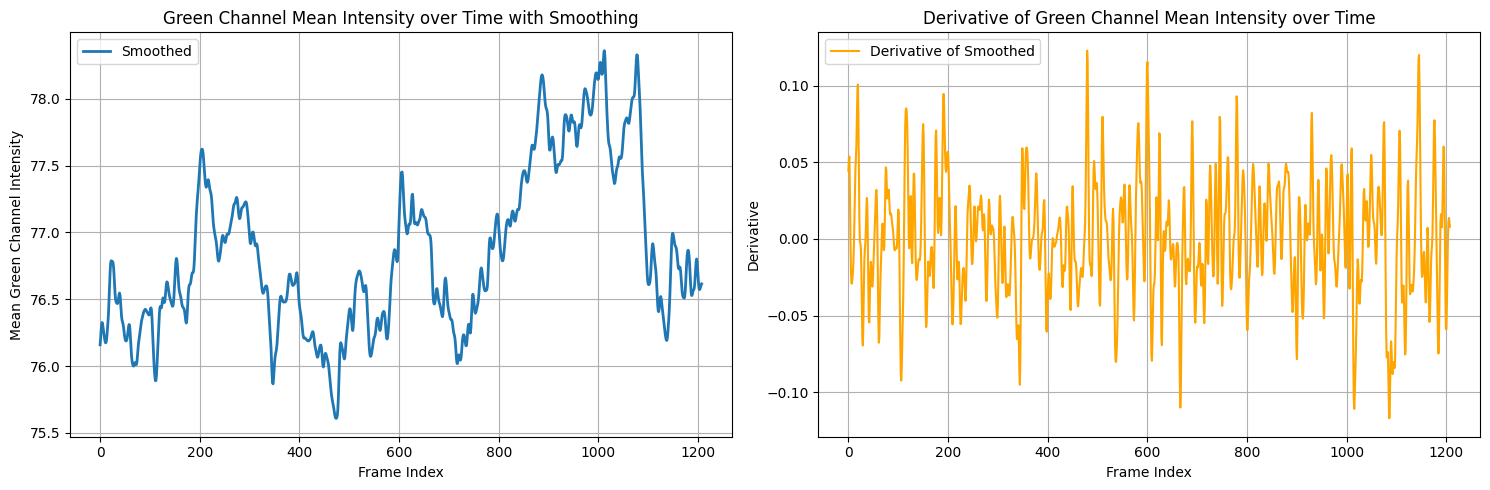

In [14]:
# 미분을 계산하기 위한 함수 정의
def derivative(signal):
    # 중앙 차분을 사용하여 미분 계산
    return np.gradient(signal)

# 스무딩된 신호의 미분 계산
diff_smoothed_green_channel = derivative(smoothed_green_channel)

# 스무딩된 신호와 미분된 신호 시각화
plt.figure(figsize=(15, 5))

# 원본 신호 그래프
plt.subplot(1, 2, 1)
# plt.plot(green_channel_intensities, label='Original')
plt.plot(smoothed_green_channel, label='Smoothed', linewidth=2)
plt.title('Green Channel Mean Intensity over Time with Smoothing')
plt.xlabel('Frame Index')
plt.ylabel('Mean Green Channel Intensity')
plt.legend()
plt.grid(True)

# 미분된 신호 그래프
plt.subplot(1, 2, 2)
plt.plot(diff_smoothed_green_channel, label='Derivative of Smoothed', color='orange')
plt.title('Derivative of Green Channel Mean Intensity over Time')
plt.xlabel('Frame Index')
plt.ylabel('Derivative')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

푸리에 변환을 사용하지 않고 시간 도메인에서 직접 피크 간격을 측정함으로써 BPM을 추정할 수 있음.

이 방법은 주로 실시간 또는 단일 시계열 데이터에 적합하며, 심박수와 같이 규칙적인 사이클을 가진 생체 신호에서 특히 유용함

In [15]:
# 피크 찾기
peaks, _ = find_peaks(smoothed_green_channel, distance=19)  # 최소 BPM을 가정하여 distance 설정

# 피크 간의 간격 계산 (프레임 단위)
peak_intervals = np.diff(peaks)

# 프레임 간격을 시간(초)으로 변환
peak_intervals_in_seconds = peak_intervals / fps

# BPM 계산
bpm_values = 60 / peak_intervals_in_seconds

# 평균 BPM 계산
average_bpm = np.mean(bpm_values)

print(f"Average BPM: {average_bpm}")

Average BPM: 42.371884829373336
